In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# NLP packages
import nltk, re
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Word cloud packages
from wordcloud import WordCloud
from pprint import pprint
import seaborn as sns

In [ ]:
df = pd.read_csv('amazon_alexa.tsv', sep='\t')
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


# 1. EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [ ]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [ ]:
# Checks for Null values
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [ ]:
# Checks for duplicate values
len(df[df.duplicated()])

715

In [ ]:
# drop them
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
df.describe()

,rating,feedback
count,2435.000000,2435.000000
mean,4.435318,0.909240
std,1.109562,0.287326
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


Text(0.5, 1.0, 'Histogram of Ratings')

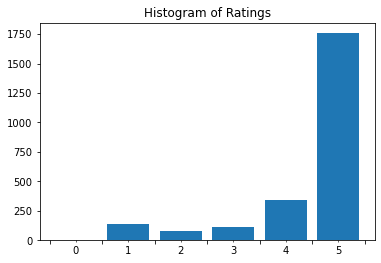

In [ ]:
fig, ax = plt.subplots()
ax.hist(df.rating, bins=range(7), rwidth=0.8)
ax.xaxis.set_minor_locator(tkr.AutoMinorLocator(n=2))
ax.xaxis.set_minor_formatter(tkr.FixedFormatter(range(7)))
ax.xaxis.set_major_formatter(tkr.NullFormatter())
plt.title("Histogram of Ratings")

In [ ]:
pos_review = df[df.feedback == 1]
neg_review = df[df.feedback == 0]

In [ ]:
pos_review.describe()

,rating,feedback
count,2214.000000,2214.0
mean,4.742096,1.0
std,0.541849,0.0
min,3.000000,1.0
25%,5.000000,1.0
50%,5.000000,1.0
75%,5.000000,1.0
max,5.000000,1.0


In [ ]:
neg_review.describe()

,rating,feedback
count,221.000000,221.0
mean,1.361991,0.0
std,0.481667,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,1.000000,0.0
75%,2.000000,0.0
max,2.000000,0.0


In [ ]:
# The date range of the data is from May 16, 2018 to July 31, 2018
df.date.unique()

array(['31-Jul-18', '30-Jul-18', '29-Jul-18', '28-Jul-18', '27-Jul-18',
       '26-Jul-18', '25-Jul-18', '24-Jul-18', '23-Jul-18', '22-Jul-18',
       '21-Jul-18', '20-Jul-18', '19-Jul-18', '18-Jul-18', '17-Jul-18',
       '16-Jul-18', '15-Jul-18', '14-Jul-18', '13-Jul-18', '12-Jul-18',
       '11-Jul-18', '10-Jul-18', '9-Jul-18', '8-Jul-18', '7-Jul-18',
       '6-Jul-18', '5-Jul-18', '4-Jul-18', '3-Jul-18', '2-Jul-18',
       '1-Jul-18', '30-Jun-18', '29-Jun-18', '28-Jun-18', '27-Jun-18',
       '26-Jun-18', '25-Jun-18', '24-Jun-18', '23-Jun-18', '22-Jun-18',
       '21-Jun-18', '20-Jun-18', '19-Jun-18', '18-Jun-18', '17-Jun-18',
       '16-Jun-18', '15-Jun-18', '14-Jun-18', '13-Jun-18', '12-Jun-18',
       '11-Jun-18', '10-Jun-18', '9-Jun-18', '8-Jun-18', '7-Jun-18',
       '6-Jun-18', '5-Jun-18', '4-Jun-18', '3-Jun-18', '2-Jun-18',
       '1-Jun-18', '31-May-18', '30-May-18', '29-May-18', '28-May-18',
       '27-May-18', '26-May-18', '25-May-18', '24-May-18', '23-May-18',
       '22

In [ ]:
len(df.date.unique())

77

In [ ]:
df['date'].value_counts()[0:11]

30-Jul-18    1072
29-Jul-18     329
28-Jul-18     232
26-Jul-18      85
31-Jul-18      68
25-Jul-18      43
27-Jul-18      38
19-Jul-18      38
20-Jul-18      28
21-Jul-18      26
24-Jul-18      25
Name: date, dtype: int64

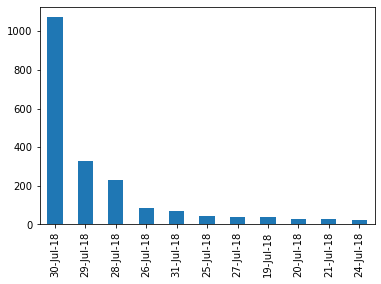

In [ ]:
df['date'].value_counts()[0:11].plot.bar()

In [ ]:
total_count = df['date'].count()
top_3_count = df['date'].value_counts()[0:3].sum()
top_3_count/total_count

0.6706365503080082

We can see that data from July 28, 2018 to July 31, 2018 accounts for 67% of the whole data.

In [ ]:
# Drop 'variation' (can be discussed and changed) 
# personally i find this column useless for us
del df['variation']

In [ ]:
df

,rating,date,verified_reviews,feedback
0,5,31-Jul-18,Love my Echo!,1
1,5,31-Jul-18,Loved it!,1
2,4,31-Jul-18,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Music,1
...,...,...,...,...
2430,5,30-Jul-18,"I do love these things, i have them running my...",1
2431,5,30-Jul-18,Only complaint I have is that the sound qualit...,1
2432,4,29-Jul-18,Good,1
2433,5,29-Jul-18,Nice little unit no issues,1


In [ ]:
feedback = df.feedback

# 2. Text Cleaning

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
#the purpose of clean_review function is to remove stopwords, punctuation, 
#special characters as well as extra spaces
def clean(review):    
    # Convert words to lower case and split them
    review = review.lower()
    # Clean the text
    review = re.sub(r"<br />", " ", review)
    review = re.sub(r"[^a-z]", " ", review)
    review = re.sub(r"   ", " ", review) # Remove any extra spaces
    review = re.sub(r"  ", " ", review)
    #remove stopwords
    tokenized = word_tokenize(review)
    review = [w for w in tokenized if not w in stop_words]
    review = " ".join(review)

    # Return a list of words
    return(review)

In [ ]:
text = []
for i in range(len(df.verified_reviews)):
    text.append(clean(df.verified_reviews[i]))

In [ ]:
df['cleaned'] = text

In [ ]:
new_df = df[df.cleaned != ""]

In [ ]:
new_df = new_df.reset_index(drop = True)

In [ ]:
# The new data frame with the cleaned reviews
new_df

,rating,date,verified_reviews,feedback,cleaned
0,5,31-Jul-18,Love my Echo!,1,love echo
1,5,31-Jul-18,Loved it!,1,loved
2,4,31-Jul-18,"Sometimes while playing a game, you can answer...",1,sometimes playing game answer question correct...
3,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing yr old learns dinosaurs control ...
4,5,31-Jul-18,Music,1,music
...,...,...,...,...,...
2374,5,30-Jul-18,"I do love these things, i have them running my...",1,love things running entire home tv lights ther...
2375,5,30-Jul-18,Only complaint I have is that the sound qualit...,1,complaint sound quality great mostly use comma...
2376,4,29-Jul-18,Good,1,good
2377,5,29-Jul-18,Nice little unit no issues,1,nice little unit issues


# 3. Sentiment Analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
# Example of the sentiment analysis result
sia.polarity_scores("Wow, NLTK is really powerful!")

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [ ]:
# If the computed polarity score is greater than 0, then it will be categorized as positive,
# if the computed polarity score is less than or equal to 0, then it will be categorized as negative,
new_df['polarity_scores'] = new_df['cleaned'].map(lambda text: sia.polarity_scores(text)['compound'])
new_df.loc[new_df['polarity_scores'] > 0, 'sentiment'] = 'positive' 
new_df.loc[new_df['polarity_scores'] <= 0, 'sentiment'] = 'negative' 

In [ ]:
new_df

,rating,date,verified_reviews,feedback,cleaned,polarity_scores,sentiment
0,5,31-Jul-18,Love my Echo!,1,love echo,0.6369,positive
1,5,31-Jul-18,Loved it!,1,loved,0.5994,positive
2,4,31-Jul-18,"Sometimes while playing a game, you can answer...",1,sometimes playing game answer question correct...,0.0516,positive
3,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing yr old learns dinosaurs control ...,0.9169,positive
4,5,31-Jul-18,Music,1,music,0.0000,negative
...,...,...,...,...,...,...,...
2374,5,30-Jul-18,"I do love these things, i have them running my...",1,love things running entire home tv lights ther...,0.9648,positive
2375,5,30-Jul-18,Only complaint I have is that the sound qualit...,1,complaint sound quality great mostly use comma...,0.8957,positive
2376,4,29-Jul-18,Good,1,good,0.4404,positive
2377,5,29-Jul-18,Nice little unit no issues,1,nice little unit issues,0.4215,positive


Text(0.5, 1.0, 'Review Sentiments Distrubition')

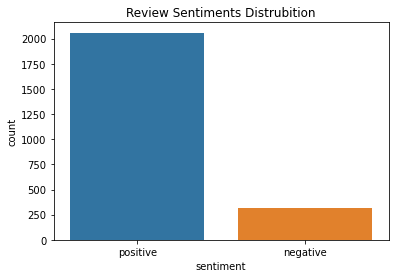

In [ ]:
sns.countplot(new_df['sentiment'])
plt.title('Review Sentiments Distrubition')

In [ ]:
new_df.sentiment.value_counts()

positive    2059
negative     320
Name: sentiment, dtype: int64

Accuracy:  0.8579234972677595
Sensitivity:  0.8959963184537506
Specificity:  0.4563106796116505
Balanced Accuracy:  0.6761534990327005


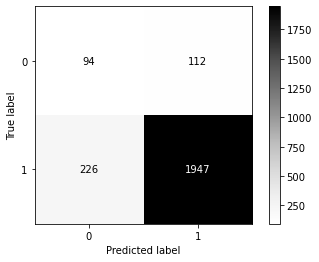

In [ ]:
new_df.loc[new_df['polarity_scores'] > 0, 'pred'] = 1 
new_df.loc[new_df['polarity_scores'] <= 0, 'pred'] = 0 
confusionMatrix = confusion_matrix(new_df.feedback, new_df.pred)
diagram = metrics.ConfusionMatrixDisplay(confusionMatrix,display_labels=None)
diagram.plot(cmap = 'Greys')

TN = confusionMatrix[0][0]
FN = confusionMatrix[1][0]
TP = confusionMatrix[1][1]
FP = confusionMatrix[0][1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
balanced_accuracy = (sensitivity + specificity) / 2

print("Accuracy: ", accuracy)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Balanced Accuracy: ", balanced_accuracy)

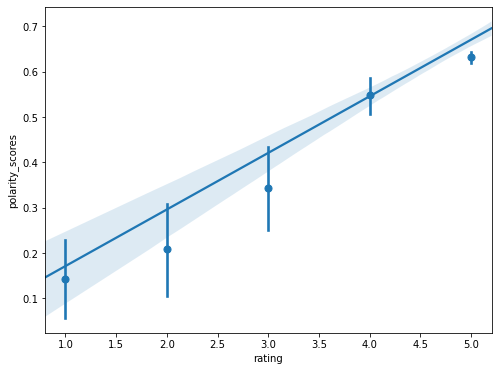

In [ ]:
# Visualize the relationship between sentiment analysis and the ratings

plt.figure(figsize=(8, 6))
plt.style
sns.regplot(x='rating', y='polarity_scores', data=new_df,x_estimator=np.mean,truncate=False,robust=True, x_jitter=0.8)

plt.show()

# 4. Word Cloud

In [ ]:
# create a function to plot wordcloud 
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(20.0,15.0), 
                   title = None, title_size=35, image_color=False):
    stopwords = stop_words
    more_stopwords = {'echo','thing'} # add more stopwords
    stopwords = stopwords.union(more_stopwords) # combine two sets of stopwords

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 123,
                    width=600, 
                    height=300)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.title(title, fontsize=title_size)
    plt.axis('off');
    plt.tight_layout()  

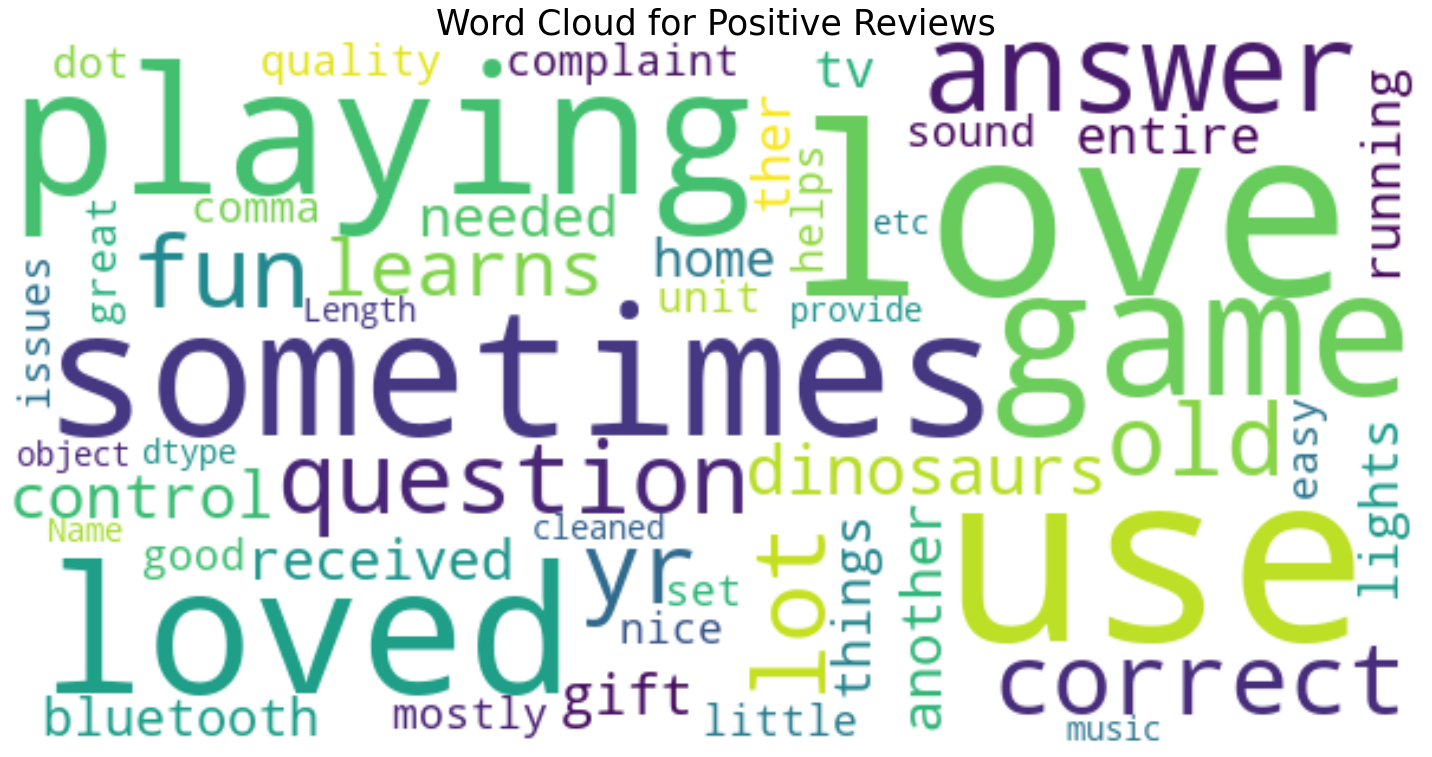

In [ ]:
plot_wordcloud(new_df[new_df.sentiment == 'positive']['cleaned'], title = 'Word Cloud for Positive Reviews')

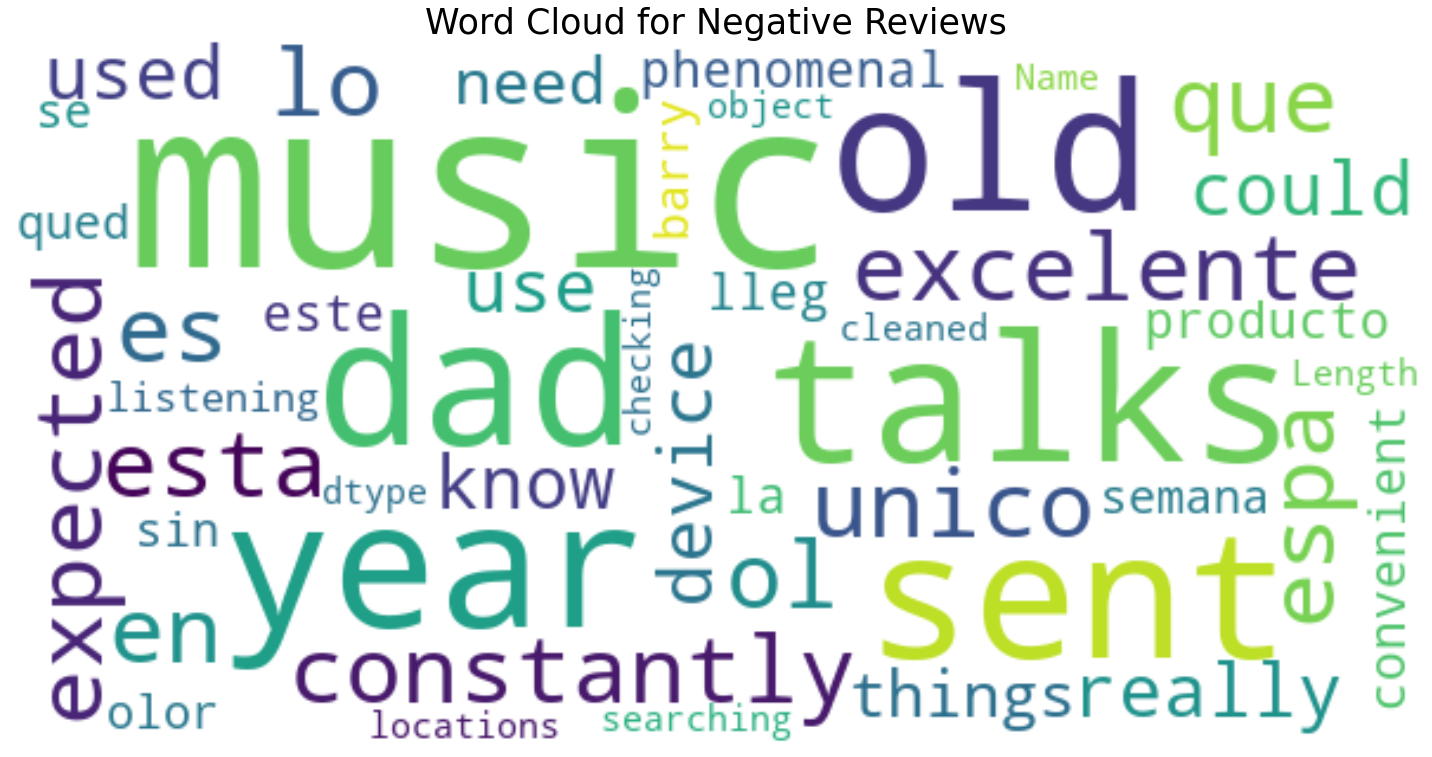

In [ ]:
plot_wordcloud(new_df[new_df.sentiment == 'negative']['cleaned'], title = 'Word Cloud for Negative Reviews')

# 5. Topic Modeling

In [ ]:
df2 = new_df
positive_text = df2[df2.sentiment == 'positive']['cleaned'].tolist()
negative_text = df2[df2.sentiment == 'negative']['cleaned'].tolist()

In [ ]:
stopwords = stop_words
more_stopwords = {'echo','thing','amazon','dot','one'} # add more stopwords
stopwords = stopwords.union(more_stopwords)

def remove_stopwords(text):
    return [[w for w in i if w not in stopwords] for i in text]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [ ]:
def topic_modeling(text,num_topics = 3):
    # Convert sentences to words
    data_words = list(sent_to_words(text))
    data_words = remove_stopwords(data_words)

    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Build LDA model

    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=id2word, passes=15, random_state= 12)
    
    # Save Model
    lda_model.save('model.gensim')
    
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

In [ ]:
topic_modeling(positive_text)

[(0,
  '0.056*"easy" + 0.042*"use" + 0.042*"set" + 0.026*"works" + 0.024*"product" '
  '+ 0.024*"love" + 0.024*"great" + 0.015*"music" + 0.013*"bedroom" + '
  '0.009*"room"'),
 (1,
  '0.034*"love" + 0.022*"like" + 0.016*"smart" + 0.013*"alexa" + 0.011*"get" + '
  '0.011*"bought" + 0.010*"home" + 0.009*"really" + 0.009*"device" + '
  '0.008*"things"'),
 (2,
  '0.037*"great" + 0.033*"alexa" + 0.027*"music" + 0.022*"works" + '
  '0.020*"love" + 0.019*"good" + 0.013*"speaker" + 0.012*"sound" + '
  '0.012*"house" + 0.011*"still"')]


### Positive topics:
1. Easy|Music|Bedroom|Room
2. Smart|Alexa|Home|Device
3. Alexa|Music|Speaker|Sound

In [ ]:
topic_modeling(negative_text)

[(0,
  '0.010*"device" + 0.010*"work" + 0.009*"everything" + 0.008*"bought" + '
  '0.007*"still" + 0.007*"music" + 0.006*"need" + 0.006*"working" + 0.005*"tv" '
  '+ 0.005*"like"'),
 (1,
  '0.016*"use" + 0.013*"alexa" + 0.012*"music" + 0.012*"alarm" + 0.010*"set" + '
  '0.009*"device" + 0.008*"phone" + 0.007*"time" + 0.006*"app" + '
  '0.006*"quality"'),
 (2,
  '0.014*"alexa" + 0.010*"refurbished" + 0.008*"expected" + 0.008*"works" + '
  '0.008*"get" + 0.008*"new" + 0.007*"work" + 0.007*"product" + 0.007*"day" + '
  '0.006*"would"')]


### Negative topics:
1. Everything|Still|Music|TV
2. Music|Alarm|Phone|Time|App
3. Refurbished|Expected|New|Work